In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [91]:
sr = pd.read_csv("data/2017_all.csv")
schools = pd.read_csv("data/entities.csv")

In [106]:
santuaries  = {'Alameda','Contra Costa','Los Angeles','Monterey','Napa','Riverside','Sacramento','San Bernardino','San Diego','San Francisco','San Mateo','Santa Clara','Santa Cruz','Sonoma'
}


{'Sacramento', 'San Francisco', 'Santa Clara ', 'San Diego', 'San Mateo', 'Riverside', 'Monterey', 'Sonoma', 'Santa Cruz', 'Contra Costa', 'Alameda', 'San Bernardino', 'Napa', 'Los Angeles'}


our data frame sr,School Record, now contains contains all the information about student scores and populations. Our issue is that it also contains information about a number of other student groups we are not interested in, like disability status. the next issue we will want to deal with are the asterisks rows. from reading the survey methodology, we know these represent an ommitted score. scores are ommitted if they represent the average of fewer than 10 students. this concerns us because it means we dont have data for classes that contain fewer than 10 migrant students. there is an option to group students by school and not by grade will give us more schools with non-ommitted information for the migrant students. each of these entries has a school code we will join with the enties list that contains school and zip codes.

In [92]:
#we remove any empty data as well as data for district summary. only non zero school codes map to actual schools.
mask = sr['Area 1 Percentage Below Standard'] != '*'
sr = sr[mask]
mask = sr['School Code'] > 0
sr = sr[mask]
sr['Mean Scale Score'] = pd.to_numeric(sr['Mean Scale Score'])
sr.shape

(1434757, 32)

In [93]:
#Selecting only the math scores to minimize language bias
mask = sr['Test Type']=='B'
sr = sr[mask]
mask = sr['Test Id'] == 2
#selecting the pool of all students at each school
mask = sr['Grade'] == 3
sr = sr[mask]

In [94]:
#we will now segemnt to get two list of schools with the scores for the total and migrant population
all_mask = sr['Subgroup ID'] == 1
migrant_mask = sr['Subgroup ID'] == 28
school_all = sr[all_mask]
school_migrant = sr[migrant_mask]
school_all.iloc[3]

County Code                               1
District Code                         10017
School Code                          124172
Filler                                  NaN
Test Year                              2017
Subgroup ID                               1
Test Type                                 B
Total Tested At Entity Level            178
Total Tested with Scores                177
Grade                                     3
Test Id                                   1
CAASPP Reported Enrollment               52
Students Tested                          50
Mean Scale Score                     2500.1
Percentage Standard Exceeded          54.00
Percentage Standard Met               24.00
Percentage Standard Met and Above     78.00
Percentage Standard Nearly Met         8.00
Percentage Standard Not Met           14.00
Students with Scores                     50
Area 1 Percentage Above Standard      54.00
Area 1 Percentage Near Standard       32.00
Area 1 Percentage Below Standard

In [95]:
school_all_scores = school_all[['School Code','Mean Scale Score']]
school_migrant_scores = school_migrant[['School Code','Mean Scale Score']]
school_all_scores = school_all_scores.rename(index=str, columns={"Mean Scale Score":"all score"})
school_migrant_scores = school_migrant_scores.rename(index=str, columns={"Mean Scale Score":"migrant score"})
print(np.mean(school_migrant_scores['migrant score']))

2378.4005780346806


In [96]:
#now we will join the two data frames using school code as the index
print(school_migrant_scores.shape)
school_all_scores = school_all_scores.drop_duplicates('School Code')
school_list = school_migrant_scores.merge(school_all_scores,how='left',on='School Code')
print(school_list.shape)
#school_list

(173, 2)
(173, 3)


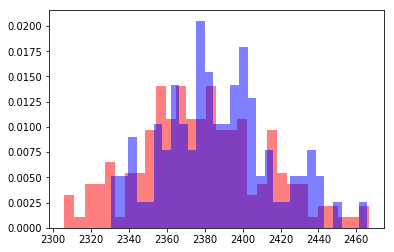

In [97]:
_ = plt.hist(school_list['migrant score'],bins = 30,color ='red',alpha=.5,normed =True)
_ = plt.hist(school_list['all score'],bins =30,color = 'blue',alpha = .5,normed = True)
plt.show()

In [102]:
school_list = school_list.merge(schools,how='inner',on='School Code')
school_list.shape

(173, 12)

In [104]:
#now we have each school with its zip code, total and migrant scores we will merge data about santuary counties
school_list['County Name']

0            Alameda
1            Alameda
2             Fresno
3             Fresno
4             Fresno
5             Fresno
6             Fresno
7             Fresno
8             Fresno
9             Fresno
10          Imperial
11          Imperial
12          Imperial
13          Imperial
14          Imperial
15          Imperial
16          Imperial
17          Imperial
18          Imperial
19          Imperial
20          Imperial
21          Imperial
22          Imperial
23          Imperial
24              Kern
25              Kern
26              Kern
27              Kern
28              Kern
29              Kern
           ...      
143    Santa Barbara
144    Santa Barbara
145    Santa Barbara
146    Santa Barbara
147    Santa Barbara
148       Santa Cruz
149       Santa Cruz
150       Santa Cruz
151       Santa Cruz
152       Santa Cruz
153       Santa Cruz
154       Santa Cruz
155       Santa Cruz
156       Santa Cruz
157       Santa Cruz
158           Sonoma
159          